In [1]:
from scipy.optimize import linprog
from math import sqrt

import random
import copy
import math
import matplotlib.pyplot as plt 
import timeit

random.seed(42)

/Users/Devansh/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def solve_price_matrix(pred_treat_effect, ab_matrix):
    # verify dimensions -- need to have a, b for each treatment
    assert(len(pred_treat_effect[0]) == len(ab_matrix[0]) == len(ab_matrix[1]))
    
    price_matrix = copy.deepcopy(pred_treat_effect)
    
    # the price p(i,t) is a linear function of the input 
    # price = a * (PTE) + b
    for i in range(len(pred_treat_effect)):
        for j in range(len(pred_treat_effect[0])):
            price_matrix[i][j] = ab_matrix[0][j]*pred_treat_effect[i][j] + ab_matrix[1][j]
            
    return price_matrix

In [3]:
def solve_demand_matrix(wtp_matrix, price_matrix, budget_list):
    # verify dimensions
    # same number of subjects
    assert(len(wtp_matrix) == len(price_matrix) == len(budget_list))
    # same number of treatments
    assert(len(wtp_matrix[0]) == len(price_matrix[0]))
    
    prob_matrix = []
    global linprog_count
    
    # for feasibility condition
    feasibility = [[1 for x in row] for row in wtp_matrix]
    feasibility_budget = [1 for x in budget_list]
    x_bounds = (0, 1)
    
    # convert wtp_matrix to negative for maximization using linprog
    wtp_temp = [[-x for x in row] for row in wtp_matrix]
    
    # solve LP problem row by row
    for i, row in enumerate(wtp_temp):
        res = linprog(wtp_temp[i], A_ub=price_matrix[i], b_ub=budget_list[i],
                  A_eq=feasibility, b_eq=feasibility_budget, 
                  bounds=(x_bounds,)*len(wtp_temp[0]), options=dict(bland=True, tol=1e-15))
        linprog_count += 1
        if (res.success == False):
            print "linprog not successful"
            print res
        prob_matrix.append(res.x.tolist())
    
    return prob_matrix

In [4]:
def solve_excess_demand(demand_matrix, capacity_list):
    # make sure the dimensions make sense
    # we have a capacity for each treatment
    assert (len(demand_matrix[0]) == len(capacity_list))
    
    # sum along the columns of demand_matrix to get total demand
    total_demand_list = [0]*len(capacity_list)
    for i in demand_matrix:
        for j, val in enumerate(i):
            total_demand_list[j] += val
    
    # subtract to get excess demand
    excess_demand = [x1 - x2 for x1, x2 in zip(total_demand_list, capacity_list)]
    return excess_demand

In [5]:
def solve_clearing_error(excess_demand_matrix):
    sum_squares = sum([x**2 for x in excess_demand_matrix])
    return sqrt(sum_squares)

In [6]:
def random_ab(b, l):
    a_list = [random.randint(-b, 0) for b in range(l)]
    b_list = [random.randint(-b, b) for b in range(l)]
    return [a_list, b_list]

In [7]:
def get_nbr_ab_values(ab_matrix, excess_demand_list, k):
    nbr = [[(ab_matrix[0][t] + excess_demand_list[t]*k) for t in range(len(excess_demand_list))], 
           [(ab_matrix[1][t] + excess_demand_list[t]*k) for t in range(len(excess_demand_list))]]
    return nbr
    
def get_nbr_clear_price_tuple(nbr_ab_val, pred_treat_effect, wtp_matrix, budget_list, capacity_list):
    nbr_price = solve_price_matrix(pred_treat_effect, nbr_ab_val)
    nbr_demand = solve_demand_matrix(wtp_matrix, nbr_price, budget_list)
    nbr_excess_demand = solve_excess_demand(nbr_demand, capacity_list)
    nbr_clearing_err = solve_clearing_error(nbr_excess_demand)
    return (nbr_clearing_err, nbr_ab_val)
    
def get_nbrs(ab_matrix, excess_demand_list, k_list, pred_treat_effect, wtp_matrix, budget_list, capacity_list):
    nbr_list = []
    for k in k_list:
        nbr_ab_val = get_nbr_ab_values(ab_matrix, excess_demand_list, k)
        nbr_tup = get_nbr_clear_price_tuple(nbr_ab_val, pred_treat_effect, wtp_matrix, budget_list, capacity_list)
        nbr_list.append(nbr_tup)
    
    return sorted(nbr_list)

In [8]:
# find the price matrix that clears the market
def algo1(wtp_matrix, pred_treat_effect, capacity_list, budget_list):
    k_list = [2**i for i in range(10)] # this defines how neighbors are computed
    best_err = float("inf") # initialization code
    best_p = []
    cur_time = 0
    
    best_err_list = []
    search_err_list = []
    cur_err_list = []
    
    while (cur_time < THRESHOLD): # hyperparameter for number of search starts
        ab_matrix = random_ab(budget_list[0], len(wtp_matrix[0]))
        price_matrix = solve_price_matrix(pred_treat_effect, ab_matrix)
        # solve utility maximization problem
        demand_matrix = solve_demand_matrix(wtp_matrix, price_matrix, budget_list)
        excess_demand_list = solve_excess_demand(demand_matrix, capacity_list)
        search_err = solve_clearing_error(excess_demand_list)
        
        tabu_list = set() # new tabu list for every search 
        c = 0 # number of steps taken without improving error
        cand_ab, cand_p, cand_d = [], [], []
        
        # take up to 5 steps in a direction tolerating increasing error
        while c < 5:
            nbr_list = get_nbrs(ab_matrix, excess_demand_list, k_list, pred_treat_effect, wtp_matrix, budget_list, capacity_list)
            found_n_step = False
            while not(found_n_step) and (nbr_list):
                cand_ab = nbr_list.pop(0)[1] # get a candidate price
                cand_p = solve_price_matrix(pred_treat_effect, cand_ab)
                cand_d = solve_demand_matrix(wtp_matrix, cand_p, budget_list)
                tup_cand_d = tuple([tuple(x) for x in cand_d])
                if tup_cand_d not in tabu_list:
                    found_n_step = True
            if not(nbr_list): # list is empty
                c = 5 # force restart
            else:
                ab_matrix = cand_ab
                price_matrix = cand_p
                tabu_list.add(tup_cand_d)
                excess_d = solve_excess_demand(cand_d, capacity_list)
                cur_err = solve_clearing_error(excess_d)
                cur_err_list.append(cur_err)
                
                if cur_err < search_err: # update error in this search
                    search_err = cur_err
                    search_err_list.append(search_err)
                    c = 0
                else:
                    c += 1
                
                if cur_err < best_err: # update best error so far
                    best_err = cur_err
                    best_err_list.append(best_err)
                    best_p = cand_p
        
        cur_time += 1
    
    print "err:", best_err
    print "price:", best_p
    best_d = solve_demand_matrix(wtp_matrix, best_p, budget_list)
    print "best_d:", best_d
    
    return best_p, best_d, best_err, best_err_list, search_err_list, cur_err_list

In [21]:
SUB = 5
TREAT = 5
# matrix of WTP -- subjects along rows, treatments along columns
wtp_matrix = [[1, 2, 3], [2, 1, 3]]
wtp_rand = [[random.randint(1, 10) for i in range(TREAT)] for x in range(SUB)]
print wtp_rand

# matrix of predicted treatment effect -- subjects along rows, treatments along columns
pred_matrix = [[1, 2, 3], [2, 1, 3]]
pred_rand = [[random.randint(1, 10) for i in range(TREAT)] for x in range(SUB)]
print pred_rand

budget_list = [100]*SUB
capacity_list = [1]*TREAT

[[7, 1, 1, 8, 3], [4, 2, 1, 8, 6], [8, 5, 8, 6, 2], [6, 10, 1, 8, 9], [6, 5, 10, 1, 5]]
[[5, 7, 5, 10, 1], [1, 7, 1, 3, 7], [6, 4, 10, 6, 5], [7, 1, 8, 9, 7], [8, 8, 3, 5, 3]]


In [22]:
THRESHOLD = 10
linprog_count = 0

start_time = timeit.default_timer()
best_p, best_d, best_err, best_l, search_l, cur_l = algo1(wtp_rand, pred_rand, capacity_list, budget_list)
print(timeit.default_timer() - start_time)

err: 1.17347641976
price: [[0.0, -1.0, -7.0, 675.0, -130.0], [0.0, -1.0, -3.0, 248.0, -514.0], [0.0, -1.0, -12.0, 431.0, -386.0], [0.0, -1.0, -10.0, 614.0, -514.0], [0.0, -1.0, -5.0, 370.0, -258.0]]
best_d: [[0.8518518518518519, 0.0, 0.0, 0.14814814814814814, 0.0], [0.0, 0.0, 0.0, 0.8057742782152231, 0.1942257217847769], [1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0]]
5.28425598145


In [45]:
ab_matrix = random_ab(budget_list[0], len(wtp_matrix[0]))
price_matrix = solve_price_matrix(pred_matrix, ab_matrix)
demand_matrix = solve_demand_matrix(wtp_matrix, price_matrix, budget_list)
print demand_matrix

AssertionError: 

In [54]:
print len(best_l)
print len(search_l)
print len(cur_l)

1
0
10


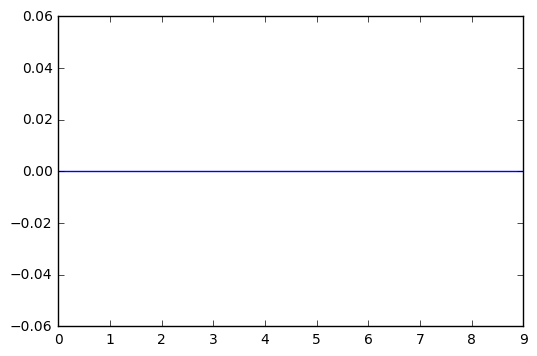

In [22]:
plt.plot(cur_l)
plt.show()

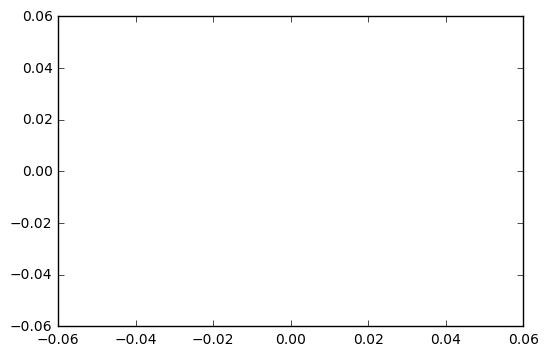

In [23]:
plt.plot(search_l)
plt.show()

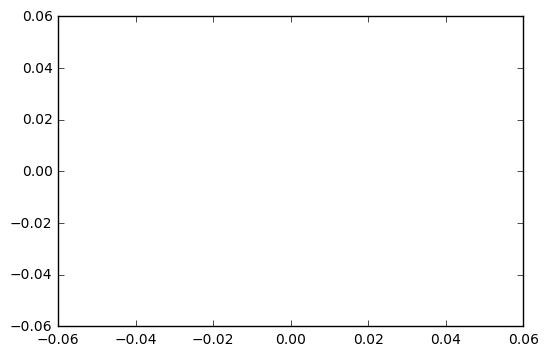

In [24]:
plt.plot(best_l)
plt.show()

In [25]:
print linprog_count

642
